<a href="https://colab.research.google.com/github/simonme42/ANN_experiments/blob/master/ANN_from_scratch_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN from scratch

*   In this notebook, we implement an artificial neural network from scratch.
*   All we need are a few standard python libraries
*   At the end we´ll test our ANN implementation on image classification and regression tasks






In [0]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
import math

%matplotlib inline

# The functions that we need to implement a NN



*   cost function: binary crossentropy, mse
*   optimization algorithms: gradient descent, Adam



In [0]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object
    
    # When z <= 0, set dz to 0 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initialize_parameters_deep(layer_dims):
    
    #np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation="relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y, loss="crossentropy"):
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    if loss == "crossentropy":
      logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
      cost_total =  np.sum(logprobs)
    
    elif loss == "mse":
      cost_total = (np.sum((AL-Y)**2,axis=1, keepdims=True))
    
    cost_total = np.squeeze(cost_total)      # To make sure the cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost_total.shape == ())
    
    return cost_total

def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, loss="crossentropy"):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation

    if loss == "crossentropy":
      dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    elif loss == "mse":
      dAL = 2*(AL-Y)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate, decay=True, decay_param=0.95, epoch=0):
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        if decay==True:
          # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
          parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - ((decay_param**epoch)*learning_rate) * grads["dW" + str(l+1)]
          parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - ((decay_param**epoch)*learning_rate) * grads["db" + str(l+1)]
        elif decay==False:
          # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
          parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
          parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size*k : mini_batch_size*(k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k : mini_batch_size*(k+1)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size*(k+1):]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*(k+1):]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,beta1 = 0.9, 
                                beta2 = 0.999,  epsilon = 1e-8, decay=True, decay_param=0.95, epoch=0):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-(beta1**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1-(beta1**t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * grads['dW' + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * grads['db' + str(l+1)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-(beta2**t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1-(beta2**t))

        if decay==True:
          # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
          parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - ((decay_param**epoch)*learning_rate) * (v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
          parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - ((decay_param**epoch)*learning_rate) * (v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon))
        elif decay==False:
          # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
          parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
          parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon))
    return parameters, v, s

def predict(X, y, parameters, loss="crossentropy"):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network

    if loss == "crossentropy":
     
      p = np.zeros((1,m))
        
      # Forward propagation
      probas, caches = L_model_forward(X, parameters)
        
      # convert probas to 0/1 predictions
      for i in range(0, probas.shape[1]):
          if probas[0,i] > 0.5:
            p[0,i] = 1
          else:
            p[0,i] = 0
      
      print("Accuracy: "  + str(np.sum((p == y)/m)))

    elif loss == "mse":

      p, caches = L_model_forward(X, parameters)

      print("Accuracy: "  + str((1/m)*np.sum(p-y)**2))
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    
    return p

def print_mislabeled_images(classes, X, y, p):

    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

def train_model(X, Y, layers_dims, learning_rate = 0.0075, num_epochs = 3000, print_cost=True, 
                loss="crossentropy", optimizer="GD", mini_batch_size=64, decay=True, decay_param=0.95):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples

    parameters = initialize_parameters_deep(layers_dims)

    # Initialize the optimizer
    if optimizer == "GD":
        pass # no initialization required for gradient descent
    elif optimizer == "Adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop 
    for i in range(num_epochs):
        # Define the random minibatches
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            AL, caches = L_model_forward(minibatch_X, parameters)
            
            # Compute cost
            cost_total += compute_cost(AL, minibatch_Y, loss=loss)
        
            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches, loss=loss)
    
            # Update parameters depending on optimization algorithm
            if optimizer == "GD":
                parameters = update_parameters(parameters, grads, learning_rate, decay=decay, decay_param=decay_param, epoch=i)
            elif optimizer == "Adam":
                t = t + 1 # Adam counter
                parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, decay=decay, decay_param=decay_param, epoch=i)
                    
        cost_avg = cost_total / m
        
        # Print the cost every 100 epoch
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            costs.append(cost_avg)          
            
    # plot the cost
    print(cost_avg)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters


# Now we train and test our NN on binary image classification using cat vs noncat



In [0]:
!git clone https://github.com/simonme42/ANN_experiments.git

fatal: destination path 'ANN_experiments' already exists and is not an empty directory.


In [0]:
def load_data():
  train_dataset = h5py.File("ANN_experiments/datasets/train_catvnoncat.h5", "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File("ANN_experiments/datasets/test_catvnoncat.h5", "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost after epoch 0: 2.237152
Cost after epoch 100: 0.008304
Cost after epoch 200: 0.001412
Cost after epoch 300: 0.000930
Cost after epoch 400: 0.000790
Cost after epoch 500: 0.000733
Cost after epoch 600: 0.000709
Cost after epoch 700: 0.000699
Cost after epoch 800: 0.000695
Cost after epoch 900: 0.000693
0.0006916847028211691


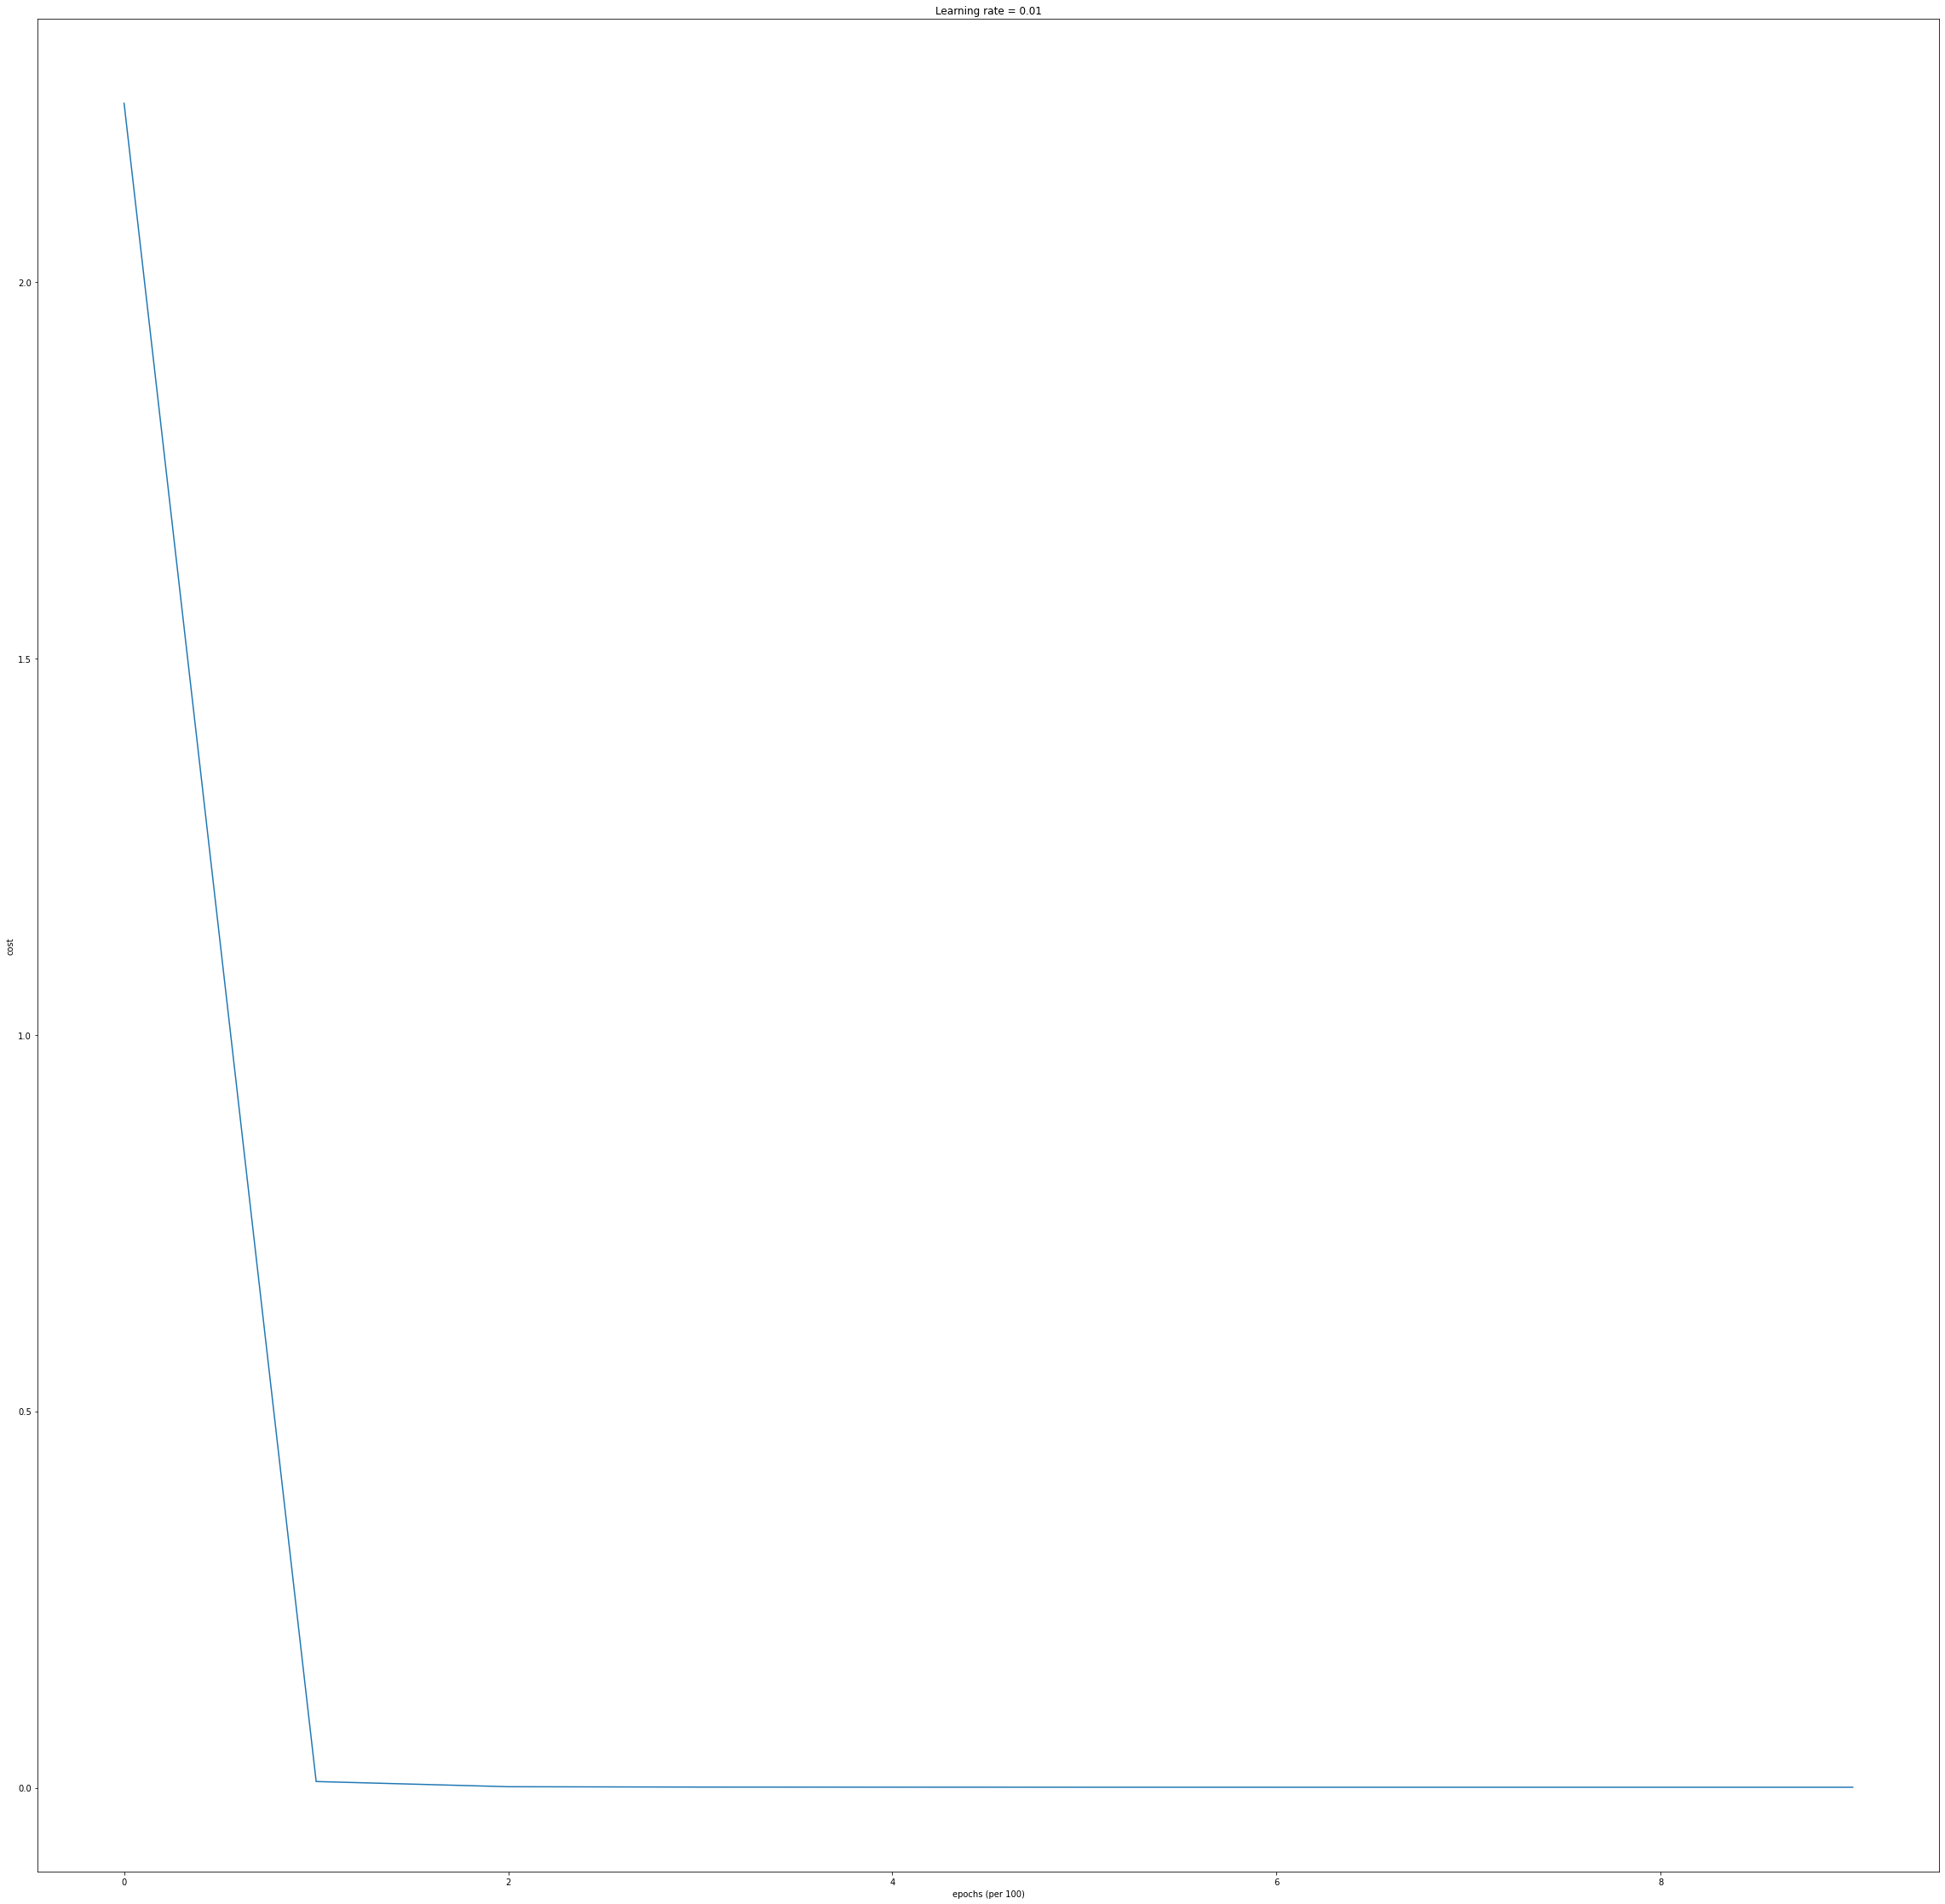

In [0]:
layers_dims = [train_x.shape[0], 30, 20, 10, 1]

parameters = train_model(train_x, train_y, layers_dims, learning_rate = 0.01, num_epochs = 1000, print_cost=True, loss="crossentropy", optimizer = "Adam", decay_param=0.99)

In [0]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.7000000000000001


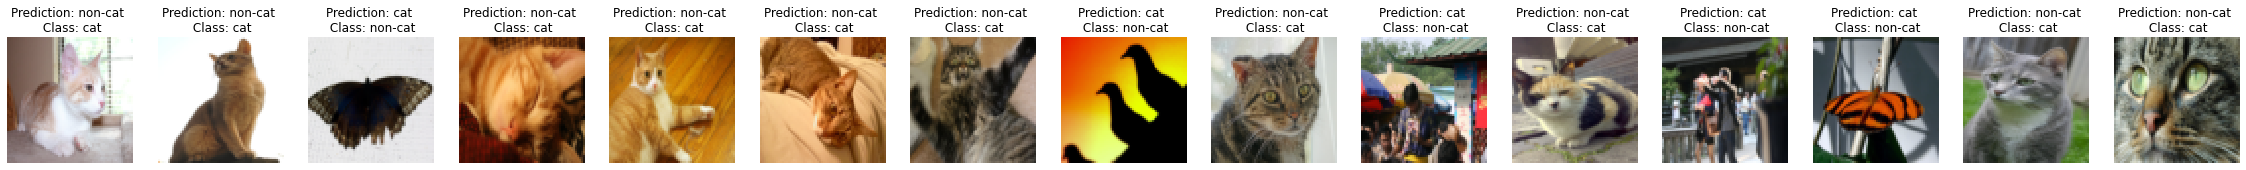

In [0]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

## Now we use our NN implementation for a Regression task (adding 2 numbers)

In [0]:
def create_mse_data(low, high, m, train_test_split=0.2):

  mse_X = np.random.randint(low,high=high, size=(2,m))
  mse_X_scaled = mse_X/(high)

  mse_Y = (np.copy(mse_X[0,:])+np.copy(mse_X[1,:])).reshape(1,mse_X.shape[1])
  mse_Y_scaled = mse_Y/(high*2)

  mse_X_train = mse_X_scaled[:,0:int(m*train_test_split)]
  mse_X_test = mse_X_scaled[:,int(m*train_test_split):]
  mse_Y_train = mse_Y_scaled[:,0:int(m*train_test_split)]
  mse_Y_test = mse_Y_scaled[:,int(m*train_test_split):]

  return (mse_X_train,mse_X_test,mse_Y_train,mse_Y_test)

(mse_X_train,mse_X_test,mse_Y_train,mse_Y_test) = create_mse_data(0,50,10000)

layers_dims_mse = [mse_X_train.shape[0],20,10,1]

Cost after epoch 0: 0.030557
Cost after epoch 100: 0.000074
Cost after epoch 200: 0.000071
Cost after epoch 300: 0.000071
Cost after epoch 400: 0.000071
7.134950342273813e-05


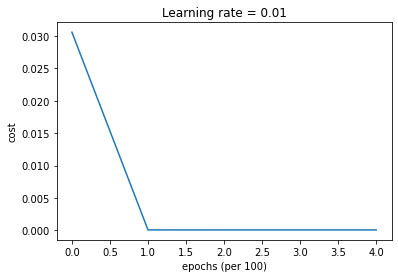

In [34]:
parameters = train_model(mse_X_train, mse_Y_train, layers_dims_mse, num_epochs = 500, print_cost = True, loss="mse", learning_rate = 0.01, optimizer="Adam", decay=True)

In [0]:
pred_train = predict(mse_X_train, mse_Y_train, parameters, loss="mse")

p, caches = L_model_forward(mse_X_train, parameters)
print((p*100-mse_Y_train*100)[:,0:50])

In [36]:
pred_test = predict(mse_X_test, mse_Y_test, parameters, loss="mse")

p, caches = L_model_forward(mse_X_test, parameters)

print((mse_Y_test*100)[:,0:10])
print((p*100)[:,0:10])
print((p*100-mse_Y_test*100)[:,0:50])

Accuracy: 0.0006100407676041495
[[86. 29. 54. 54. 46. 33. 22. 44. 88. 62.]]
[[84.88538087 28.96829726 54.2279861  53.36040842 45.74449742 32.50018121
  22.37971545 43.47278965 86.15738845 61.92819917]]
[[-1.11461913 -0.03170274  0.2279861  -0.63959158 -0.25550258 -0.49981879
   0.37971545 -0.52721035 -1.84261155 -0.07180083 -0.69414788 -0.14133485
  -0.4741958   0.63422703  0.08962758 -0.01045398 -0.25174946  1.0251103
   1.04428401 -2.86862667 -0.32755644  0.71740734 -0.11421237 -0.15919325
  -0.48472517  0.46385045  0.5973477  -0.4083406   0.54352383  0.63422703
  -0.16482968 -0.5587995   0.35954031  0.24258637 -0.69414788  0.53533292
   0.6502479  -0.64760833 -0.21742527  0.01495328 -0.49916706  0.54706629
  -0.27722557  0.3632829   0.11273155 -0.47483833  0.1850751  -0.07859833
  -0.49012669 -0.96414096]]
